In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import seaborn as sns
# import pandas as pd
# import torch.nn as nn
from sklearn.datasets import fetch_openml
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression  # NEW
import numpy as np, pandas as pd, torch
from sklearn.datasets import (
    load_wine, load_breast_cancer, load_iris, load_digits,
    make_classification, make_regression, load_diabetes,
    fetch_california_housing
)

import warnings

from math import ceil

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor
)
from sklearn.neural_network import MLPClassifier, MLPRegressor

# optional XGBoost (silently skipped if not installed)
try:
    from xgboost import XGBClassifier, XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

### Data Creation

In [4]:
# ! pip install openml
# from openml import fetch_openml


In [37]:
# pip install pygam
import copy
# ---- Boston Housing ----
# Newer sklearn: load via openml
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def label_encode_columns(df, columns):
    """
    Label-encodes specified categorical columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        columns (list): List of column names to encode.
        
    Returns:
        pd.DataFrame: DataFrame with encoded columns.
        dict: Dictionary of fitted LabelEncoders (one per column).
    """
    encoders = {}
    df_copy = df.copy()  # avoid modifying original df
    
    for col in columns:
        le = LabelEncoder()
        df_copy[col] = df_copy[col].astype(str)  # handle NaN by converting to string
        df_copy[col] = le.fit_transform(df_copy[col])
        encoders[col] = le  # save encoder if you want to inverse_transform later
    
    return df_copy, encoders

tdf = sns.load_dataset("titanic")
tdf.dropna( inplace=True)
y_titanic = tdf["survived"]
X_titanic_ = tdf.drop(columns=["survived", "deck", "embark_town"], errors="ignore")
X_titanic, _ = label_encode_columns(
    X_titanic_, ["sex", "embarked", "class", "who", "adult_male", "alone","alive"]
)
# boston = fetch_openml(name="boston", version=1, as_frame=True)
# X_boston, y_boston = boston.data, boston.target

# # ---- Titanic ----
# titanic = fetch_openml(name="titanic", version=1, as_frame=True)
# df_= titanic.data.drop(columns=["ticket",'name','home.dest'], errors="ignore")  # drop target if inside data
# X_titanic,le=label_encode_columns(df_, ["sex","cabin", "embarked", "boat"])
# y_titanic = titanic.target #if "survived" in titanic else titanic.data["survived"]

# ---- Put them in dictionary ----
# datasets = {
#     "boston": (X_boston, y_boston),
#     "titanic": (X_titanic, y_titanic)
# }

# ---- Usage ----
# for name, (X, y) in datasets.items():
#     print(f"{name}: X shape = {X.shape}, y shape = {y.shape}")
# print("yes")

def load_seaborn_diamonds(as_frame=True):
    df = sns.load_dataset("diamonds").dropna()
    y = df["price"].astype(float)  # continuous target
    X = df.drop(columns=["price"])
    # optional: cast categoricals (one-hot later)
    for c in ["cut","color","clarity"]:
        if c in X.columns:
            X[c] = X[c].astype("category")
    return (X, y) if as_frame else (X.to_numpy(), y.to_numpy())

X_diam, y_diam = load_seaborn_diamonds()
X_diam,_=label_encode_columns(X_diam, ["cut","color", "clarity"])
# ===== Pipeline =====
datasets = {
    # "diamonds": (X_diam.values, y_diam.values),
    # "titanic": (X_titanic.values, y_titanic.values),
    # # "boston": (X_boston, y_boston),
    # "wine": load_wine(),
    "breast_cancer": load_breast_cancer(),
    # "iris": load_iris(),
    # "digits": load_digits(n_class=3),
#     "make_classification": make_classification(n_samples=500, n_features=10, n_informative=5, random_state=0),
#     "diabetes": load_diabetes(),             # regression
#     "california": fetch_california_housing(),# regression
#     "make_regression": make_regression(n_samples=500, n_features=10, n_informative=5, noise=0.1, random_state=0)

}

# datasets["diamonds"] = (X_diam, y_diam)
# importance_tables = []



In [38]:
# X_titanic.values
# X_diam

In [39]:
# ---- helper: robust task detection (uses your earlier list if present) ----
classification_datasets = [
    "wine", "breast_cancer", "iris", "digits", "make_classification","titanic"
]

def _infer_task(ds_name: str, y):
    if ds_name in classification_datasets:
        return "classification"
    # fallback: many unique targets or floaty -> regression
    return "regression" if (np.issubdtype(np.asarray(y).dtype, np.floating) or np.unique(y).size > 20) else "classification"


### KAN-Based Models

In [58]:
class KANLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True, base_activation=torch.nn.SiLU,
                 grid_eps=0.02, grid_range=(-1.0, 1.0), eps=1e-8):
        super().__init__()
        self.in_features, self.out_features = in_features, out_features
        self.grid_size, self.spline_order = grid_size, spline_order
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.scale_noise, self.scale_base, self.scale_spline = scale_noise, scale_base, scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps
        self.eps = eps

        # Knots (open uniform with order padding)
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]) \
               .expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)

        # Parameters
        self.base_weight   = torch.nn.Parameter(torch.empty(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(torch.empty(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.ones(out_features, in_features))  # start at 1.0

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5)
                     * self.scale_noise / max(1, self.grid_size))
            coeff = self.curve2coeff(self.grid.T[self.spline_order:-self.spline_order], noise)
            if self.enable_standalone_scale_spline:
                self.spline_weight.copy_(coeff)      # scaler handles the amplitude
            else:
                self.spline_weight.copy_(self.scale_spline * coeff)

    def b_splines(self, x: torch.Tensor):
        """Return B-spline basis: (B, in, grid_size + spline_order)."""
        assert x.dim() == 2 and x.size(1) == self.in_features
        B = x.size(0)
        x = x.to(self.grid.dtype).unsqueeze(-1)  # (B, in, 1)
        grid = self.grid  # (in, K+2p+1)

        # Initial piecewise-constant basis (order 0)
        # Make the final interval right-closed to avoid dropping rightmost values
        left = x >= grid[:, :-1]
        right = x < grid[:, 1:]
        right_last = x <= grid[:, 1:]
        bases = (left & right).to(x.dtype)
        bases[:, :, -1] = (left[:, :, -1] & right_last[:, :, -1]).to(x.dtype)

        # Cox–de Boor recursion with safe denominators
        for k in range(1, self.spline_order + 1):
            denom_left  = (grid[:, k:-1]  - grid[:, :-(k+1)]).clamp_min(self.eps)
            denom_right = (grid[:, k+1:]  - grid[:, 1:(-k)]).clamp_min(self.eps)
            term_left  = ((x - grid[:, :-(k+1)]) / denom_left)  * bases[:, :, :-1]
            term_right = ((grid[:, k+1:] - x) / denom_right)    * bases[:, :,  1:]
            bases = term_left + term_right

        Keff = self.grid_size + self.spline_order
        assert bases.size() == (B, self.in_features, Keff)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        x: (K+1, in), y: (K+1, in, out). Returns (out, in, K+order)
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size(0) == x.size(0) and y.size(1) == self.in_features
        A = self.b_splines(x).transpose(0, 1)  # (in, B, Keff)
        B = y.transpose(0, 1)                  # (in, B, out)
        sol = torch.linalg.lstsq(A, B, driver=None).solution  # (in, Keff, out)
        return sol.permute(2, 0, 1).contiguous()              # (out, in, Keff)

    @property
    def scaled_spline_weight(self):
        W = self.spline_weight
        if self.enable_standalone_scale_spline:
            W = W * self.spline_scaler.unsqueeze(-1)
        return W.contiguous()

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        flat = x.reshape(-1, self.in_features)
        base   = torch.nn.functional.linear(self.base_activation(flat), self.base_weight)
        Bspl   = self.b_splines(flat)
        spline = torch.nn.functional.linear(Bspl.view(flat.size(0), -1),
                                            self.scaled_spline_weight.view(self.out_features, -1))
        out = base + spline
        return out.view(*x.shape[:-1], self.out_features)
    

class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=2,
        spline_order=1,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden[:-1], layers_hidden[1:]):  #[1,3]+[3,1] (1,3), (3,1)
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )
    @torch.no_grad()
    def first_layer_contrib_importance(self, x, combine='sum', absmean=True, normalize=True):
        """
        Returns per-feature importance from the first KANLinear by measuring
        average magnitude of each feature's contribution (base + spline) on data X.
        """
        l0 = self.layers[0]
        x = torch.as_tensor(x, dtype=torch.float32)
        flat = x.reshape(-1, l0.in_features)
    
        # Base contribution per feature j → (N, out)
        a = l0.base_activation(flat)         # (N, in)
        base_contrib = torch.einsum('ni,oi->no', a, l0.base_weight)  # total base; we want per-feature
        base_contrib_j = torch.einsum('ni,oi->nio', a, l0.base_weight)  # (N, in, out)
    
        # Spline contribution per feature j → (N, out)
        Bspl = l0.b_splines(flat)            # (N, in, K)
        Ws   = l0.scaled_spline_weight       # (out, in, K)
        spline_contrib_j = torch.einsum('nik,oik->nio', Bspl, Ws)       # (N, in, out)
    
        # Per-feature magnitude on data
        contrib = base_contrib_j + spline_contrib_j                     # (N, in, out)
        if absmean:
            per_feat = contrib.abs().mean(dim=(0, 2))                   # (in,)
        else:
            per_feat = (contrib.pow(2).mean(dim=(0, 2))).sqrt()
    
        if normalize:
            s = per_feat.sum().clamp(min=1e-12)
            per_feat = per_feat / s
        return per_feat.cpu()
    @torch.no_grad()
    def get_feature_importance(self, method, x=None, y=None, task="classification", loss_fn=None, reduction="sum_logits"):
        m = method.lower()
        if m == "kan_l1":
            return self.first_layer_contrib_importance( x, combine='sum', absmean=True)    #.coef_importance('l1')|layers[0].
        if m == "kan_l2":
            return self.first_layer_contrib_importance( x, combine='sum', absmean=False)    #.coef_importance('l2')
        if m == "kan_ko":
            if x is None or y is None or loss_fn is None:
                raise ValueError("KAN-KO needs x, y, loss_fn")
            # NEW: use model-level KO that performs a FULL forward
            return self.knockout_delta_loss_full(x, y, loss_fn, task=task, normalize=True, clip_negative=True)

        if m == "kan_si":
            if x is None:
                raise ValueError("KAN-SI needs x")
            torch.set_grad_enabled(True)
            try:
                x_req = x.detach().requires_grad_(True)
                out = self.forward(x_req)
                if task == "classification":
                    if out.dim() == 2 and out.size(1) > 1:
                        obj = out.abs().sum() if reduction == "sum_logits" else out.abs().mean()
                    else:
                        obj = out.squeeze(-1).abs().sum()
                else:
                    obj = out.squeeze(-1).abs().sum()
                self.zero_grad(set_to_none=True)
                if x_req.grad is not None:
                    x_req.grad.zero_()
                obj.backward()
                grads = x_req.grad.detach().abs().mean(dim=0)
                imps = grads / (grads.sum() + 1e-12)
                return imps.cpu()
            finally:
                torch.set_grad_enabled(False)
        raise ValueError("method must be one of {'kan_l1','kan_l2','kan_si','kan_ko'}")
    @torch.no_grad()
    def knockout_delta_loss_full(self, x, y, loss_fn, *, task="regression",
                                 normalize=True, clip_negative=True):
        """
        Feature knockout measured at the FINAL head (full forward):
          - classification:   out (N,C), y (N,),     CrossEntropyLoss
          - regression:       out (N,1), y (N,1),    MSELoss
        We zero the parameters of the j-th input channel in the FIRST layer only,
        then run a FULL forward to compute the loss delta.
        """
        # ---- Base forward once (full network) ----
        base_out = self.forward(x)
    
        # Shape sanity per task
        if task == "classification":
            # logits (N,C) vs class ids (N,)
            assert base_out.ndim == 2 and y.ndim == 1, \
                f"[KO base] clf shapes: out {base_out.shape}, y {y.shape}"
        else:
            # regression: ensure y matches (N,1)
            if y.shape != base_out.shape:
                try:
                    y = y.view_as(base_out)
                except RuntimeError as e:
                    raise RuntimeError(f"[KO base] reg shapes mismatch: out {base_out.shape}, y {y.shape}") from e
    
        base_loss = float(loss_fn(base_out, y).item())
    
        # ---- Work on the first layer only ----
        l0 = self.layers[0]
        d_in = l0.in_features
        deltas = x.new_zeros(d_in)
    
        for j in range(d_in):
            # Save params tied to input feature j
            saved_base   = l0.base_weight[:, j].clone()
            saved_spline = l0.spline_weight[:, j, :].clone()
            saved_scaler = l0.spline_scaler[:, j].clone() if getattr(l0, "enable_standalone_scale_spline", False) else None
    
            # Knock out j: remove its contribution at layer 0
            l0.base_weight[:, j].zero_()
            l0.spline_weight[:, j, :].zero_()
            if saved_scaler is not None:
                l0.spline_scaler[:, j].zero_()
    
            # FULL forward again (now with feature j muted)
            out_j = self.forward(x)
    
            # Shape sanity again
            if task == "classification":
                assert out_j.ndim == 2 and out_j.shape[1] == base_out.shape[1], \
                    f"[KO step] clf out shape {out_j.shape} != (N,{base_out.shape[1]})"
            else:
                if out_j.shape != base_out.shape or out_j.shape != y.shape:
                    raise RuntimeError(f"[KO step] reg shapes: out {out_j.shape}, base {base_out.shape}, y {y.shape}")
    
            L = float(loss_fn(out_j, y).item())
            delta = L - base_loss
            if clip_negative:
                delta = max(0.0, delta)
            deltas[j] = delta
    
            # Restore params
            l0.base_weight[:, j].copy_(saved_base)
            l0.spline_weight[:, j, :].copy_(saved_spline)
            if saved_scaler is not None:
                l0.spline_scaler[:, j].copy_(saved_scaler)
    
        if normalize:
            s =  deltas.sum()
            if s > 0:
                deltas = deltas / (s+1e-12)
        return deltas.detach().cpu()



def prepare_target(y,task):
    y_arr = np.asarray(y)

    # Decide task: classification if not floating and has "few" unique values
    is_float = np.issubdtype(y_arr.dtype, np.floating)
    n_unique = np.unique(y_arr[~pd.isna(y_arr)]).size  # ignore NaNs for counting
    # task = "classification" if (not is_float and n_unique <= 50) else "regression"

    if task == "classification":
        # Handle NaNs explicitly
        if pd.isna(y_arr).any():
            raise ValueError("y contains NaNs; impute or drop them before training.")

        # If already numeric but not 0..C-1, remap; else use LabelEncoder for strings/objects
        if pd.api.types.is_numeric_dtype(y_arr) and y_arr.dtype != object:
            classes_sorted = np.sort(np.unique(y_arr))
            remap = {v: i for i, v in enumerate(classes_sorted)}
            y_enc = np.vectorize(remap.get)(y_arr)
            encoder = ("mapping", remap, classes_sorted)
        else:
            le = LabelEncoder()
            y_enc = le.fit_transform(y_arr.astype(str))
            encoder = ("labelencoder", le, le.classes_)
        return task, y_enc.astype(np.int64), encoder
    else:
        # Regression → float32
        return task, y_arr.astype(np.float32), None

# ---------- tiny helper: train KAN on one split ----------
def _train_kan(X_tr, y_tr, task, seed=0):
    X_tr = np.asarray(X_tr)
    y_tr = np.asarray(y_tr)

    torch.manual_seed(seed)
    np.random.seed(seed)

    n_in = X_tr.shape[1]
    if task == "classification":
        n_classes = int(np.unique(y_tr).shape[0])
        layers = [n_in, n_in*2+1, n_classes]

        # MUST be 1-D int64 for CrossEntropyLoss
        ytr_t = torch.as_tensor(y_tr, dtype=torch.long)              # <— FIX
        loss_fn = torch.nn.CrossEntropyLoss()
    else:
        layers = [n_in, n_in*2+1, 1]
        # Use float32 and a column vector for regression
        ytr_t = torch.as_tensor(y_tr.reshape(-1, 1), dtype=torch.float32)  # <— FIX
        loss_fn = torch.nn.MSELoss()

    model = KAN(layers_hidden=layers)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    ds = torch.utils.data.TensorDataset(
        torch.as_tensor(X_tr, dtype=torch.float32),
        ytr_t
    )
    loader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

    model.train()
    for _ in range(100):
        for xb, yb in loader:
            opt.zero_grad()
            out = model(xb)
            # CrossEntropyLoss expects: out (N,C), yb (N,) long
            # MSE expects: out (N,1), yb (N,1) float
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()

    model.eval()
    return model, loss_fn


### Pygam

In [13]:
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.5 MB/s eta 0:00:00


In [14]:
# Optional: define HAS_PYGAM and the helpers if not already present
try:
    from pygam import LogisticGAM, LinearGAM
    HAS_PYGAM = True
except Exception:
    HAS_PYGAM = False

def compute_gam_importance(X, y, task):
    if not HAS_PYGAM: 
        return None
    try:
        if task == "classification":
            if len(np.unique(y)) != 2:
                return None
            gam = LogisticGAM().fit(X, y)
            # simple permutation wrapper for consistency
            class _Wrap:
                def fit(self, X, y): return self
                def predict(self, X): 
                    p = gam.predict_proba(X)[:,1]
                    return (p >= 0.5).astype(int)
                def predict_proba(self, X):
                    p = gam.predict_proba(X)[:,1]
                    return np.c_[1-p, p]
            imp = permutation_importance(_Wrap(), X, y, n_repeats=5, random_state=0).importances_mean
        else:
            gam = LinearGAM().fit(X, y)
            class _Wrap:
                def fit(self, X, y): return self
                def predict(self, X): return gam.predict(X)
            imp = permutation_importance(_Wrap(), X, y, n_repeats=5, random_state=0).importances_mean
        imp = np.maximum(imp, 0.0)
        s = imp.sum()
        return imp / (s if s > 0 else 1.0)
    except Exception:
        return None
HAS_PYGAM

True

In [15]:

# 

### SVM RFE 

In [41]:
from sklearn.svm import LinearSVC, SVR
from sklearn.feature_selection import RFE
def compute_svm_rfe_scores(X, y, task):
    try:
        base = LinearSVC(C=1.0, penalty="l2", dual=True, max_iter=5000, random_state=0) if task=="classification" \
               else SVR(kernel="linear", C=1.0, max_iter=5000)
        sel = RFE(base, n_features_to_select=1, step=0.1)  # full ranking
        sel.fit(X, y)
        r = sel.ranking_.astype(float)          # 1 = most important
        imp = -(r - r.min() + 1e-12)            # higher is better
        imp = imp - imp.min() + 1e-12
        s = imp.sum()
        return imp/s if s>0 else np.ones(X.shape[1])/X.shape[1]
    except Exception:
        return None

### Compute Importances

In [59]:
# ---------- compute all importances on one fold (train-only where appropriate) ----------
def _importances_on_fold(X_tr, y_tr, X_val, y_val, task, has_pygam: bool):
    X_tr = np.asarray(X_tr); y_tr = np.asarray(y_tr)
    X_val = np.asarray(X_val); y_val = np.asarray(y_val)

    # KAN
    kan_model, loss_eval = _train_kan(X_tr, y_tr, task, seed=0)
    xb_tr = torch.tensor(X_tr, dtype=torch.float32)
    yb_tr = torch.tensor(y_tr if task=="classification" else y_tr.reshape(-1,1),
                         dtype=(torch.long if task=="classification" else torch.float32))

    xb_val = torch.tensor(X_val, dtype=torch.float32)
    yb_val = torch.tensor(y_val if task=="classification" else y_val.reshape(-1,1),
                         dtype=(torch.long if task=="classification" else torch.float32))
    kan_l1 = kan_model.get_feature_importance("kan_l1", x=xb_val).numpy()
    kan_l2 = kan_model.get_feature_importance("kan_l2", x=xb_val).numpy()
    # Use TRAIN data for SI/KO to avoid leakage
    kan_si = kan_model.get_feature_importance("kan_si", x=xb_val, task=task).numpy()
    kan_ko = kan_model.get_feature_importance("kan_ko", x=xb_val, y=yb_val, task=task, loss_fn=loss_eval).numpy()

    # Mutual info (train only)
    mi_fn = mutual_info_classif if task=="classification" else mutual_info_regression
    mi = mi_fn(X_tr, y_tr, random_state=0)

    # RF permutation importance: fit on train, permute on validation (correct usage)
    RF = RandomForestClassifier if task=="classification" else RandomForestRegressor
    rf = RF(n_estimators=200, random_state=0).fit(X_tr, y_tr)
    per = permutation_importance(rf, X_val, y_val, n_repeats=5, random_state=0).importances_mean

    # L1 path: Logistic L1 for cls, LassoCV for reg (train only)
    if task == "regression":
        lasso = LassoCV(cv=5, random_state=0).fit(X_tr, y_tr)
        l1 = np.abs(lasso.coef_)
    else:
        log_l1 = LogisticRegression(
            penalty="l1", solver="liblinear", C=0.1, max_iter=5000, multi_class="ovr"  # NEW: explicit ovr
        ).fit(X_tr, y_tr)
        w = np.abs(log_l1.coef_)
        l1 = w.mean(axis=0) if w.ndim==2 else np.abs(w)

    # Optional extras
    gam = compute_gam_importance(X_tr, y_tr, task) if has_pygam else None
    rfe = compute_svm_rfe_scores(X_tr, y_tr, task)

    # Normalize each vector to sum 1 (robust comparison)
    def _nz_norm(v):
        v = np.maximum(np.asarray(v, float), 0)
        s = v.sum()
        return v / (s if s > 0 else 1.0)
    out = {
        "KAN-L1": kan_l1,
        "KAN-L2": kan_l2,
        "KAN-SI": kan_si,
        "KAN-KO": kan_ko,
        "Mutual Info": _nz_norm(mi),
        "Permutation (RF)": _nz_norm(per),
        # "GAM":_nz_norm(gam) if gam is not None else np.array([100 for i in range(X_tr.shape[1])]),
        "LASSO/L1": _nz_norm(l1),
    }
    if gam is not None: out["GAM"] = _nz_norm(gam)
    if rfe is not None: out["SVM-RFE"] = _nz_norm(rfe)
    # Sanity: all vectors must have same length d
    d = X_tr.shape[1]
    for k, v in out.items():
        if v.shape[0] != d:
            warnings.warn(f"[{k}] importance length {v.shape[0]} != d={d}")
    return out

# ---------- K-fold aggregator ----------
def crossval_feature_importances(X, y, task, n_splits=5, random_state=42):
    X = np.asarray(X); y = np.asarray(y)
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state) \
         if task=="classification" else \
         KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    agg = {}  # method -> running sum vector
    has_pygam = HAS_PYGAM

    for tr_idx, va_idx in cv.split(X, y if task=="classification" else None):
        X_tr, X_val = X[tr_idx], X[va_idx]
        y_tr, y_val = y[tr_idx], y[va_idx]

        # scaler per fold (fit on train only)
        scaler = StandardScaler().fit(X_tr)
        X_tr = scaler.transform(X_tr)
        X_val = scaler.transform(X_val)

        fold_imp = _importances_on_fold(X_tr, y_tr, X_val, y_val, task, has_pygam)
        for k, v in fold_imp.items():
            agg[k] = v.copy() if k not in agg else (agg[k] + v)

    # average across folds
    for k in agg:
        agg[k] /= n_splits
    return agg


### Evaluate Predictors Based on Feature selections

In [60]:
def _expand_k_list(k_list, n_features):
    """
    Accepts integers (e.g., 5), percentage strings (e.g., '30%'), or floats in (0,1] (e.g., 0.3).
    Returns a sorted, unique list of integer ks in [1, n_features].
    """
    out = []
    for k in k_list:
        if isinstance(k, str) and k.endswith('%'):
            p = float(k[:-1]) / 100.0
            k_int = int(ceil(p * n_features))
        elif isinstance(k, (float, np.floating)) and 0 < k <= 1:
            k_int = int(ceil(k * n_features))
        else:  # assume absolute integer k
            k_int = int(k)
        k_int = max(1, min(n_features, k_int))
        out.append(k_int)
    return sorted(set(out))

def _subset_X(X, idx):
    """Column-subset that works for both NumPy and pandas."""
    return X.iloc[:, idx] if hasattr(X, "iloc") else X[:, idx]

def evaluate_predictors(
    X, y, task, feature_scores,
    k_list=("10%", "20%", "30%", "40%", "50%", "60%","70%", "80%", "90%"), n_splits=5, random_state=0,
    scoring=None
):
    """
    Evaluate predictors on top-k features selected by each selector.

    Parameters
    ----------
    X : array-like (n_samples, n_features)  (NumPy or pandas)
    y : array-like (n_samples,)
    task : {"classification","regression"}
    feature_scores : dict[str -> 1D array of shape (n_features,)]
        Precomputed feature-importance scores aligned to X's columns.
        (Make sure you computed these on TRAIN data only if you care about leakage.)
    k_list : iterable of ints, 'NN%' strings, or floats in (0,1]
    n_splits : int, CV folds
    random_state : int
    scoring : str | None
        Defaults: "accuracy" for classification, "r2" for regression.
        (You can pass "f1_macro", "roc_auc_ovr", etc.)

    Returns
    -------
    pd.DataFrame with columns: ["Selector","k","Predictor","Score"]
    """
    n_features = X.shape[1]
    k_list_int = _expand_k_list(k_list, n_features)

    results = []

    # predictors & CV setup
    if task == "classification":
        predictors = {
            "LogReg": LogisticRegression(max_iter=5000, n_jobs=None),
            "RF": RandomForestClassifier(n_estimators=200, random_state=random_state),
            "GB": GradientBoostingClassifier(random_state=random_state),
            # "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=random_state),
        }
        if HAS_XGB:
            predictors["XGB"] = XGBClassifier(
                n_estimators=300, learning_rate=0.05, max_depth=6,
                subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
                random_state=random_state, n_jobs=0, eval_metric="mlogloss"
            )
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        scoring = scoring or "f1_macro" # "accuracy"  # alternatives: 'f1_macro', 'roc_auc_ovr'
    else:
        predictors = {
            "Ridge": Ridge(),
            "RF": RandomForestRegressor(n_estimators=200, random_state=random_state),
            "GB": GradientBoostingRegressor(random_state=random_state),
            # "MLP": MLPRegressor(hidden_layer_sizes=(100,), max_iter=300, random_state=random_state),
        }
        if HAS_XGB:
            predictors["XGB"] = XGBRegressor(
                n_estimators=300, learning_rate=0.05, max_depth=6,
                subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
                random_state=random_state, n_jobs=0
            )
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        scoring = scoring or "r2"

    # 1) Baseline with all features
    for pname, pred in predictors.items():
        base = cross_val_score(pred, X, y, cv=cv, scoring=scoring).mean()
        results.append({
            "Selector": "All Features",
            "k": n_features,
            "Predictor": pname,
            "Score": base
        })
    # 2) Top-k subsets per selector
    for sel_name, scores in feature_scores.items():
        scores = np.asarray(scores)
        if scores.shape[0] != n_features:
            raise ValueError(f"[{sel_name}] scores length {scores.shape[0]} != n_features {n_features}")
        order = np.argsort(-scores)  # descending
        for k in k_list_int:
            idx = order[:k]
            Xk = _subset_X(X, idx)
            for pname, pred in predictors.items():
                s = cross_val_score(pred, Xk, y, cv=cv, scoring=scoring).mean()
                results.append({
                    "Selector": sel_name,
                    "k": k,
                    "Predictor": pname,
                    "Score": s
                })
    return pd.DataFrame(results)

### Run for all data sets

In [61]:
import re
import numpy as np
import pandas as pd
from math import ceil

# ---- helper: parse "X7" -> 7, used to align feature rows to column order ----
_feat_rx = re.compile(r"^X(\d+)$")
def _feat_idx(name: str) -> int:
    m = _feat_rx.match(str(name))
    if not m:
        raise ValueError(f"Feature name {name!r} doesn't look like 'X<i>'")
    return int(m.group(1))


# ---- main loop ----
def evaluate_all_datasets(
    datasets: dict,
    feature_importances_df: pd.DataFrame,
    k_list=("10%", "20%", "30%", "40%", "50%", "60%","70%", "80%", "90%"), #("20%", "40%", "60%"),
    n_splits=5,
    random_state=0,
    cls_scoring="f1_macro",
    reg_scoring="r2"
) -> pd.DataFrame:
    all_eval_rows = []

    for ds_name, dataset in datasets.items():
        # Unpack dataset
        X, y = (dataset if isinstance(dataset, tuple) else (dataset.data, dataset.target))

        # Infer task
        task = _infer_task(ds_name, y)

        # Split train/test
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y,
            test_size=0.2,
            random_state=random_state,
            stratify=(y if task == "classification" else None)
        )

        # Select the importance rows for this dataset
        sub = feature_importances_df[feature_importances_df["Dataset"] == ds_name].copy()
        if "Feature" not in sub.columns:
            raise ValueError(f"'Feature' column missing for dataset {ds_name}")

        sub["__idx__"] = sub["Feature"].map(_feat_idx)
        sub = sub.sort_values("__idx__")

        # Sanity check: number of features must match
        d = X.shape[1]
        if sub.shape[0] != d:
            raise ValueError(f"[{ds_name}] {sub.shape[0]} importance rows != X has {d} features")

        # Build feature_scores dict
        score_cols = [c for c in sub.columns if c not in ("Feature", "Dataset", "__idx__")]
        feature_scores = {c: sub[c].to_numpy(dtype=float) for c in score_cols}

        # Choose scoring
        scoring = cls_scoring if task == "classification" else reg_scoring

        # Evaluate
        eval_df = evaluate_predictors(
            X, y, task, feature_scores,
            k_list=k_list, n_splits=n_splits, random_state=random_state, scoring=scoring
        )
        eval_df["Dataset"] = ds_name
        eval_df["Task"] = task
        all_eval_rows.append(eval_df)

    return pd.concat(all_eval_rows, ignore_index=True)

import numpy as np
import pandas as pd

importance_tables = []

for name, dataset in datasets.items():
    X, y = (dataset if isinstance(dataset, tuple) else (dataset.data, dataset.target))
    d = X.shape[1]

    # imp_dict: dict[str -> 1D np.array length d], e.g. from crossval_feature_importances(X, y, task)
    task =  _infer_task(name, y) #"classification" if (not np.issubdtype(np.asarray(y).dtype, np.floating) and np.unique(y).size <= 20) else "regression"
    
    try:
        imp_dict = crossval_feature_importances(X, y, task, n_splits=5, random_state=42)  # or your own computation
    
        feat_names = list(X.columns) if hasattr(X, "columns") else [f"X{i}" for i in range(d)]
        df = pd.DataFrame(imp_dict, index=feat_names).reset_index().rename(columns={"index": "Feature"})
        df["Dataset"] = name
        importance_tables.append(df)
    except:
        feature_importances_data = pd.concat(importance_tables, ignore_index=True)
    

feature_importances_df = pd.concat(importance_tables, ignore_index=True)




did not converge
did not converge
did not converge
did not converge
did not converge


In [62]:
# feature_importances_df 
# now run evaluation
all_eval_df = evaluate_all_datasets(
    datasets, feature_importances_df,
    k_list=("10%", "20%", "30%", "40%", "50%", "60%","70%", "80%", "90%"), #("20%","40%","60%"),
    n_splits=5,
    random_state=0,
    cls_scoring="f1_macro",
    reg_scoring="r2"
)
all_eval_df.to_csv("predictor_eval_by_selector.csv", index=False)
all_eval_df.head()


,Selector,k,Predictor,Score,Dataset,Task
0,All Features,30,LogReg,0.948744,breast_cancer,classification
1,All Features,30,RF,0.964180,breast_cancer,classification
2,All Features,30,GB,0.962366,breast_cancer,classification
3,All Features,30,XGB,0.971561,breast_cancer,classification
4,KAN-L1,3,LogReg,0.911750,breast_cancer,classification


In [21]:
 feature_importances_df.to_csv("feature_importances_df.csv", index=False)

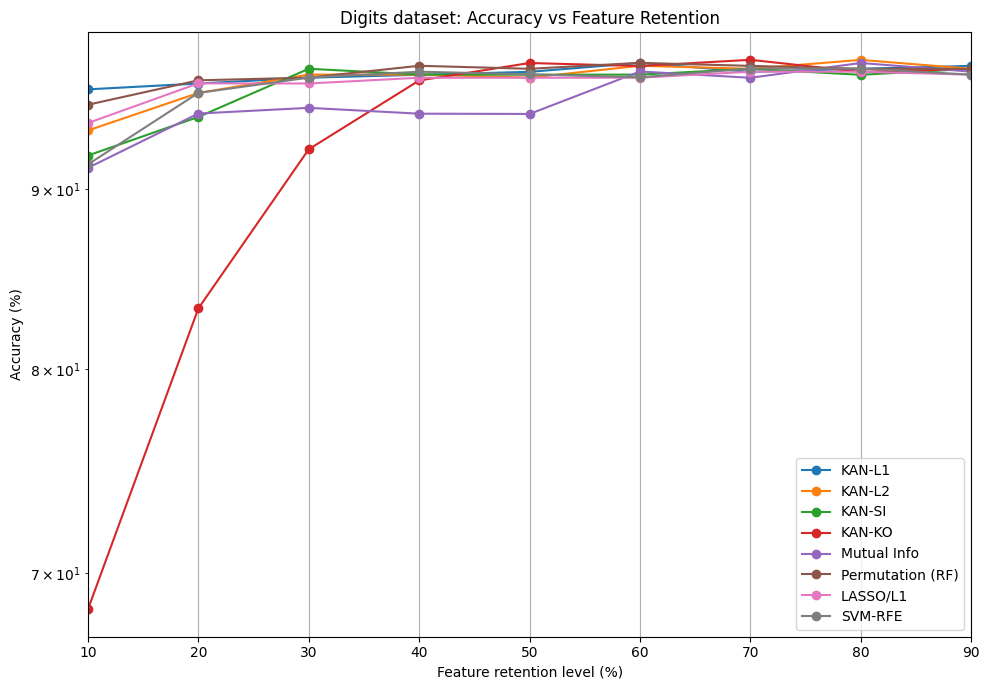

In [48]:
import pandas as pd
import matplotlib.pyplot as plt


# fi_path = "/kaggle/input/fs-data/feature_importances_Best.xlsx"
# pred_path = "/kaggle/input/fs-data/predictor_eval_results_Best.xlsx"

fi_df = feature_importances_df # pd.read_excel(fi_path)
pred_df = all_eval_df #pd.read_excel(pred_path)

# --- Filter for digits ---
digits_pred = pred_df[pred_df['Dataset'] == 'breast_cancer'].copy()

# Total number of features (from the “All Features” row: k = 64)
total_features = int(digits_pred[digits_pred['Selector'] == 'All Features']['k'].iloc[0])

# Compute retention percentage
digits_pred['retention_pct'] = 100 * digits_pred['k'] / total_features

selectors = ['KAN-L1', 'KAN-L2', 'KAN-SI', 'KAN-KO',
             'Mutual Info', 'Permutation (RF)', 'LASSO/L1', 'SVM-RFE']

plt.figure(figsize=(10, 7))

for sel in selectors:
    sub = digits_pred[digits_pred['Selector'] == sel]
    if sub.empty:
        continue
    # For each retention level take the best predictor accuracy
    agg = sub.groupby('retention_pct')['Score'].max().reset_index()
    # Keep 10–90% range
    mask = (agg['retention_pct'] >= 10) & (agg['retention_pct'] <= 90)
    agg = agg[mask]
    if agg.empty:
        continue
    plt.plot(agg['retention_pct'], agg['Score'] * 100, marker='o', label=sel)

plt.xlabel('Feature retention level (%)')
plt.ylabel('Accuracy (%)')
plt.yscale("log")
plt.title('Digits dataset: Accuracy vs Feature Retention')
plt.xlim(10, 90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


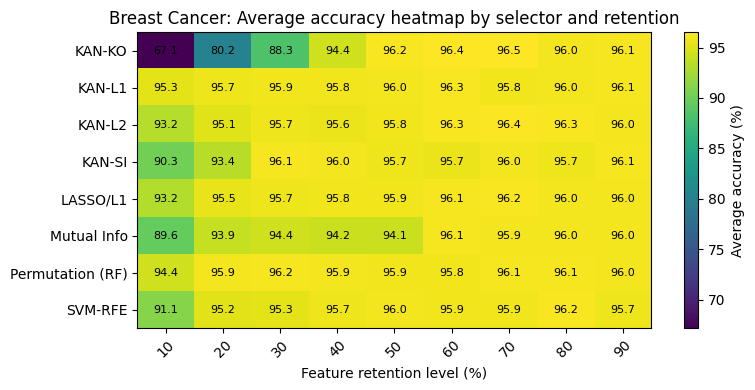

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
# pred = pd.read_csv("predictor_eval_by_selector.csv")
pred=all_eval_df
digits = pred[pred["Dataset"] == "breast_cancer"].copy()



total_features = int(digits[digits["Selector"] == "All Features"]["k"].iloc[0])
digits = digits[digits["Selector"] != "All Features"].copy()
digits["retention_pct"] = 100 * digits["k"] / total_features

# Average accuracy over predictors
agg_mean = (
    digits.groupby(["Selector", "retention_pct"])["Score"]
          .mean()
          .reset_index()
)
pivot_mean = agg_mean.pivot(index="Selector", columns="retention_pct", values="Score") * 100

plt.figure(figsize=(8, 4))
im = plt.imshow(pivot_mean.values, aspect="auto")
plt.colorbar(im, label="Average accuracy (%)")

# y-axis labels
plt.yticks(range(len(pivot_mean.index)), pivot_mean.index)

# x-axis: label from 10 to 90 (no decimals)
num_cols = len(pivot_mean.columns)
nominal_labels = [str(v) for v in range(10, 100, 10)]  # 10,20,...,90
assert num_cols == len(nominal_labels)  # should match (9)
plt.xticks(range(num_cols), nominal_labels, rotation=45)

# annotate cells
vals = pivot_mean.values
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        v = vals[i, j]
        if np.isnan(v):
            continue
        color = "white" if v < 20 else "black"
        plt.text(j, i, f"{v:.1f}", ha="center", va="center", fontsize=8, color=color)

plt.xlabel("Feature retention level (%)")
plt.title("Breast Cancer: Average accuracy heatmap by selector and retention")
plt.tight_layout()
plt.show()


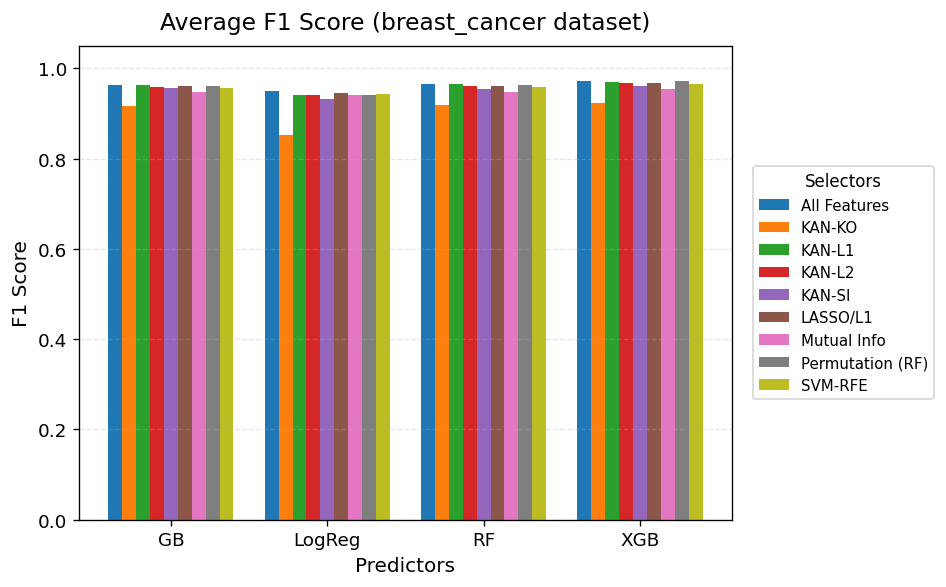

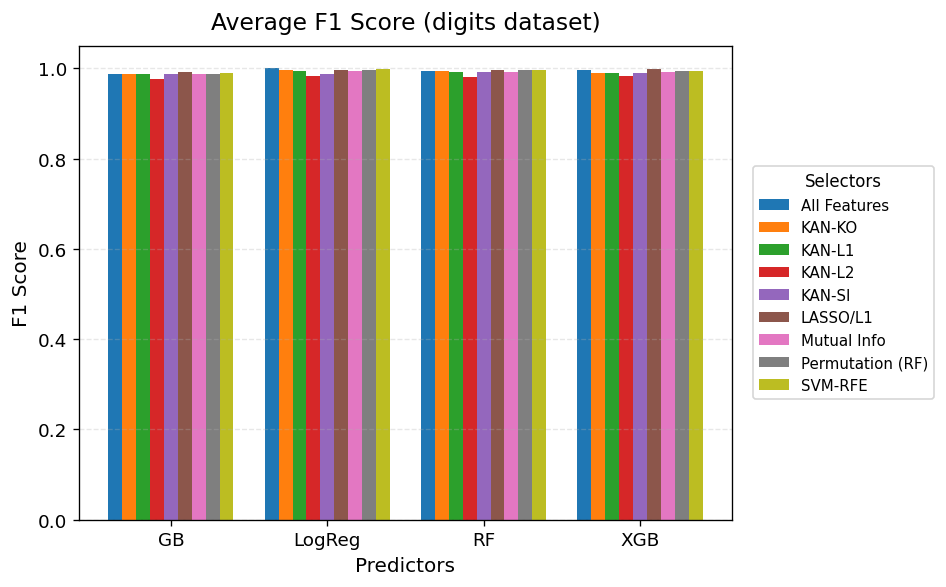

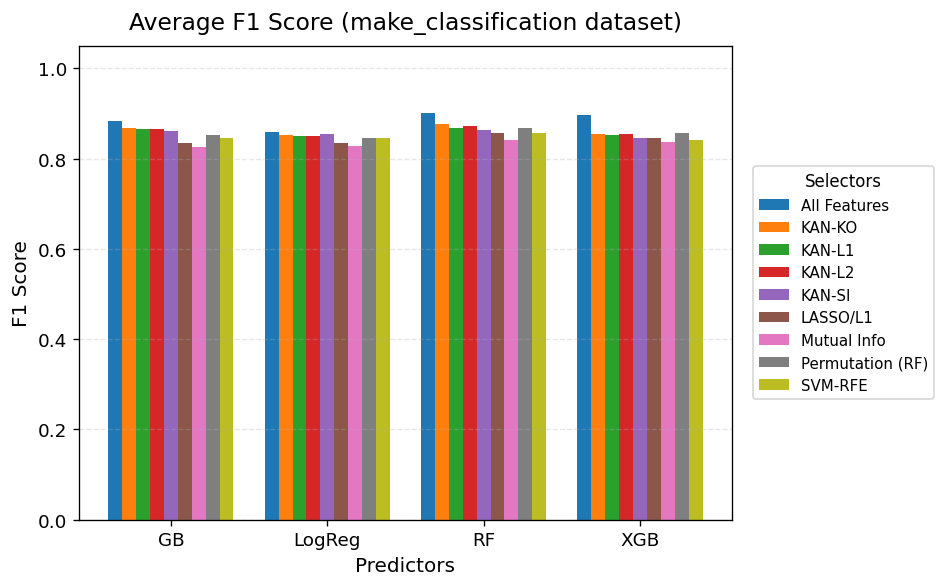

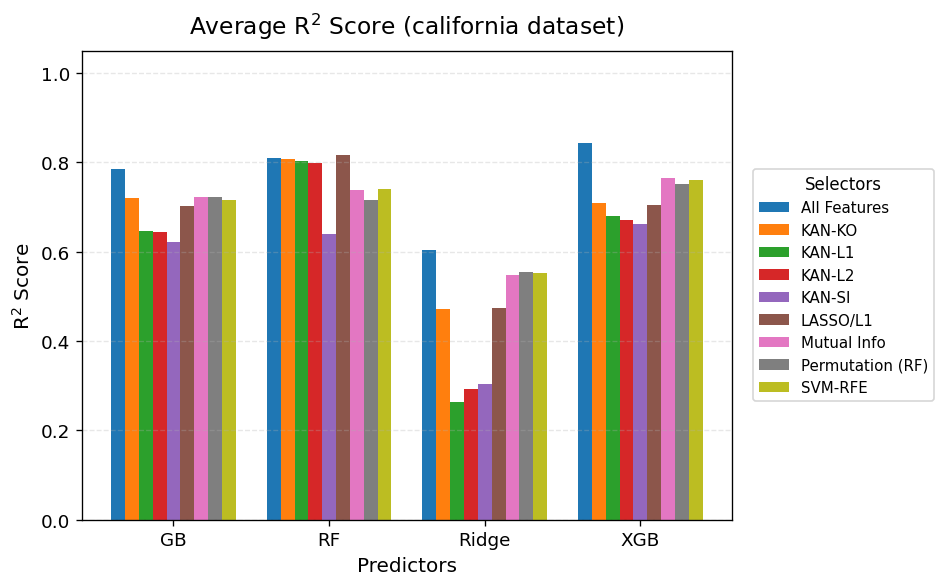

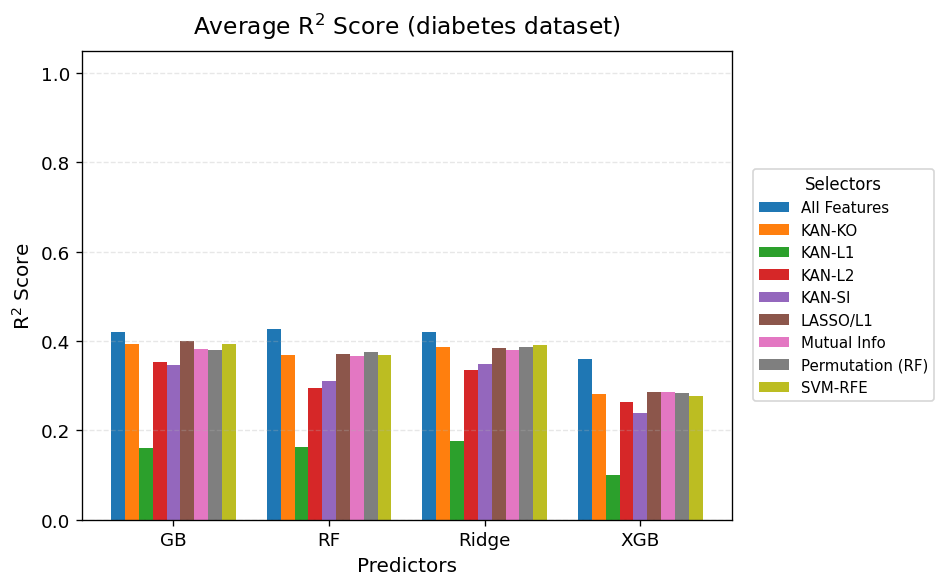

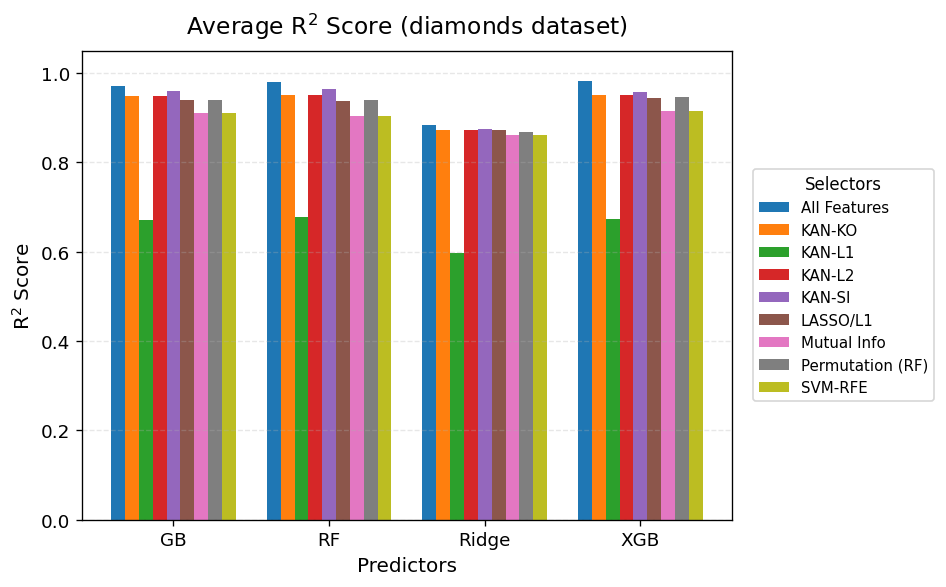

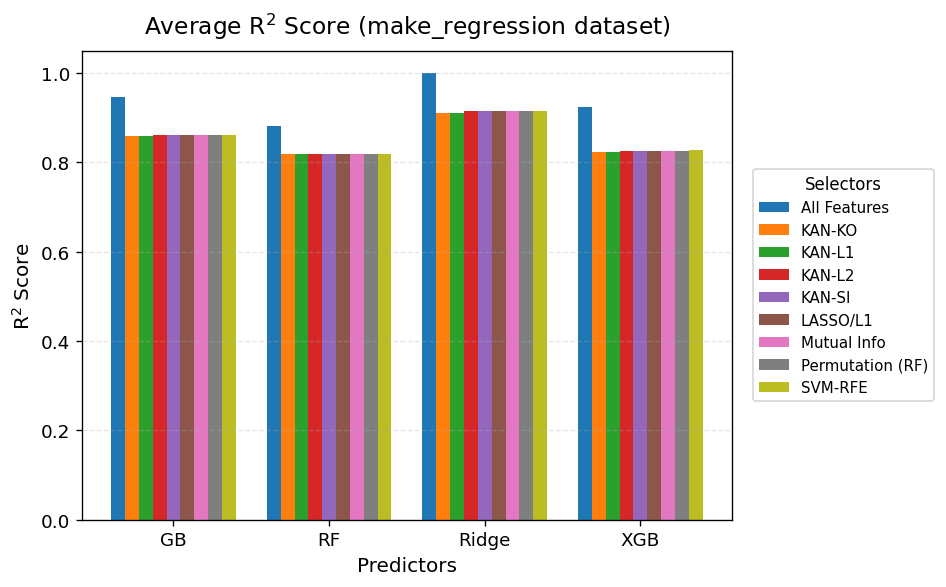

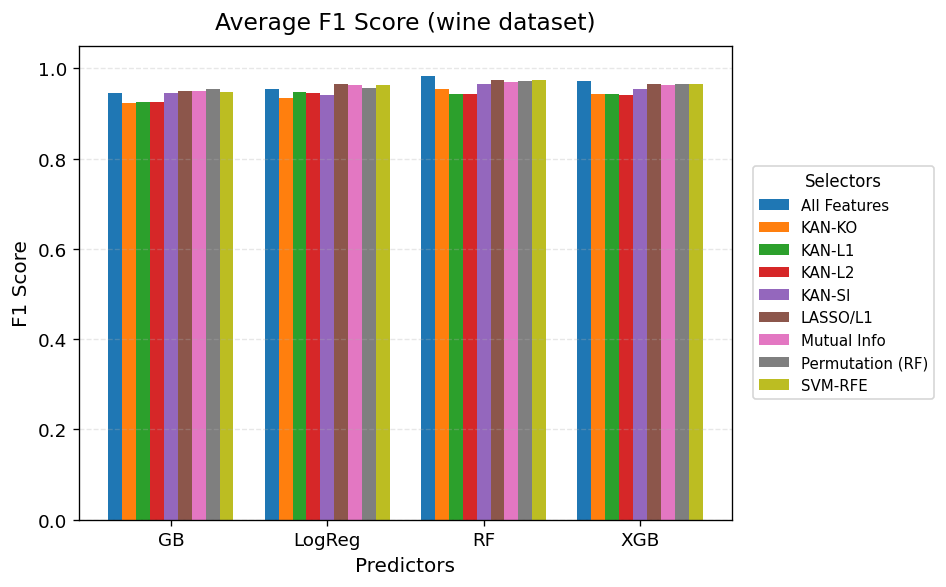

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your Excel file
df = pd.read_csv("/kaggle/input/features2/predictor_eval_by_selector.csv")

def plot_dataset_bars(df, dataset, metric_label="F1 Score"):
    """
    Plot average score (across retention levels) per predictor and selector
    for a single dataset.

    metric_label: "F1 Score" for classification or "R$^2$ Score" for regression.
    """
    sub = df[df["Dataset"] == dataset].copy()

    # Average over k (retention levels) for each Predictor × Selector
    grp = (
        sub.groupby(["Predictor", "Selector"])["Score"]
           .mean()
           .reset_index()
    )

    # Pivot to matrix: rows = predictors, columns = selectors
    pivot = grp.pivot(index="Predictor", columns="Selector", values="Score")
    predictors = pivot.index.tolist()
    selectors = pivot.columns.tolist()

    n_pred = len(predictors)
    n_sel = len(selectors)

    x = np.arange(n_pred)
    width = 0.8 / n_sel  # total group width ~0.8 of tick spacing

    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

    for i, sel in enumerate(selectors):
        values = pivot[sel].values
        # bars centered around x with small offsets
        ax.bar(x + (i - n_sel/2) * width + width/2,
               values,
               width,
               label=sel)

    # Axis formatting
    ax.set_xticks(x)
    ax.set_xticklabels(predictors, fontsize=11)
    ax.set_ylabel(metric_label, fontsize=12)
    ax.set_xlabel("Predictors", fontsize=12)
    ax.set_title(f"Average {metric_label} ({dataset} dataset)",
                 fontsize=14, pad=10)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis="y", labelsize=11)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    # Legend outside on the right
    ax.legend(title="Selectors",
              fontsize=9,
              title_fontsize=10,
              bbox_to_anchor=(1.02, 0.5),
              loc="center left",
              borderaxespad=0.5)

    fig.tight_layout()
    return fig, ax

# Examples:
# Classification datasets (F1)
# Classification datasets (F1)
fig, ax = plot_dataset_bars(df, "breast_cancer", metric_label="F1 Score")
fig.savefig("/kaggle/working/breast_cancer_f1.png", dpi=300, bbox_inches="tight")

fig, ax = plot_dataset_bars(df, "digits", metric_label="F1 Score")
fig.savefig("/kaggle/working/digits_f1.png", dpi=300, bbox_inches="tight")

fig, ax = plot_dataset_bars(df, "make_classification", metric_label="F1 Score")
fig.savefig("/kaggle/working/make_classification_f1.png", dpi=300, bbox_inches="tight")

# Regression datasets (R²)
fig, ax = plot_dataset_bars(df, "california", metric_label="R$^2$ Score")
fig.savefig("/kaggle/working/california_r2.png", dpi=300, bbox_inches="tight")

fig, ax = plot_dataset_bars(df, "diabetes", metric_label="R$^2$ Score")
fig.savefig("/kaggle/working/diabetes_r2.png", dpi=300, bbox_inches="tight")

fig, ax = plot_dataset_bars(df, "diamonds", metric_label="R$^2$ Score")
fig.savefig("/kaggle/working/diamonds_r2.png", dpi=300, bbox_inches="tight")

fig, ax = plot_dataset_bars(df, "make_regression", metric_label="R$^2$ Score")
fig.savefig("/kaggle/working/make_regression_r2.png", dpi=300, bbox_inches="tight")

fig, ax = plot_dataset_bars(df, "wine", metric_label="F1 Score")
fig.savefig("/kaggle/working/wine_f1.png", dpi=300, bbox_inches="tight")

